# Drunk Detection CNN

In [ ]:
import os
import re
import sys
import glob
import math
import time
import queue
import pickle
import random
import shutil
import pathlib
import zipfile
import threading

import requests
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, utils

# Constants
BASE_PATH = "drunk_detection_cnn"
BASE_PATH = os.path.join("drive", "MyDrive", BASE_PATH)  # Uncomment this line if Google Drive is mounted on Google Colab
DATASET_PATH = os.path.join(BASE_PATH, "dataset")
DATASET_ORIGINAL_PATH = os.path.join(DATASET_PATH, "original")
DATASET_UNZIPPED_PATH = os.path.join(DATASET_PATH, "unzipped")
DATASET_GIFS_PATH = os.path.join(DATASET_PATH, "gifs")
DATASET_TRAIN_PATH = os.path.join(DATASET_PATH, "train")
DATASET_VALIDATION_PATH = os.path.join(DATASET_PATH, "validation")
PICKLE_PATH = os.path.join(BASE_PATH, "dataset.pickle")

# Optional steps
DOWNLOAD_DATASET = False
UNZIP_DATASET = False
CREATE_GIFS = False
DOWNLOAD_THREADS = 5

# Dataset
USE_SUM = True  # Use sum of frames instead of singular frames
FEATURE = "e"  # f - face, h - hand, e - eyes, r - ear
LIMIT_SEQUENCE = 2  # 1 - sober, 2 - drunk 30min, 3 - drunk 1h, 4 - drunk 1h 30min
CLASS_WEIGHT = {0: (1/LIMIT_SEQUENCE)/2, 1: ((LIMIT_SEQUENCE-1)/LIMIT_SEQUENCE)/2}

# Data Augmentation
DATA_AUGMENTATION = True
DATA_AUGMENTATION_AMOUNT = 5
DATA_AUGMENTATION_ZOOM = 0.1
DATA_AUGMENTATION_FLIP_ENABLED = True
DATA_AUGMENTATION_FLIP = "horizontal"
DATA_AUGMENTATION_ROTATION_ENABLED = False
DATA_AUGMENTATION_ROTATION = 0.2

# Model
TRAIN_WEIGHT = 0.8
VALIDATION_WEIGHT = 0.2
EPOCHS = 50


# Classes
class SubjectData:
    def __init__(self, file):
        self.filepath = file
        self.filename = os.path.basename(file)

        # Parse metadata
        self.parse_filename()

    def parse_filename(self):
        parts = os.path.splitext(self.filename)[0].split("_")
        self.id = int(parts[0])
        self.name = parts[1]
        self.sequence = int(parts[2])
        self.feature = parts[3]
        self.sex = parts[4]
        self.age = int(parts[5])
        self.weight = int(parts[6])
        self.drunk = True if int(parts[2]) != 1 else False

    def parse_image(self):
        self.thermal_sum = np.zeros((128, 160))
        self.thermal_sum_normalized = np.zeros((128, 160))
        self.thermal_frames = np.zeros((50, 128, 160))
        self.thermal_frames_normalized = np.zeros((50, 128, 160))

        with Image.open(self.filepath) as img:
            for i in range(img.n_frames):
                img.seek(i)

                frame_data = np.array(img)
                min_val = np.amin(frame_data)
                frame_data -= min_val

                for j in range(img.height):
                    for k in range(img.width):
                        self.thermal_sum[j, k] += frame_data[j, k]

                self.thermal_frames[i] = frame_data

                # Normalize
                self.thermal_frames_normalized[i] = normalize_array(frame_data)

            # Normalize
            self.thermal_sum_normalized = normalize_array(self.thermal_sum)


# Utilities
def mkdir(path):
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)


def rmdir(path):
    try:
        shutil.rmtree(path)
    except FileNotFoundError:
        pass


def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i : i + n]


def parse_dataset_folder(path):
    subjects = []
    for file in os.listdir(path):
        subjects.append(SubjectData(os.path.join(path, file)))

    return subjects


def group_subjects(subjects):
    grouped_subjects = {}
    for subject in subjects:
        if subject.id not in grouped_subjects:
            grouped_subjects[subject.id] = []

        grouped_subjects[subject.id].append(subject)
    return grouped_subjects


def normalize_array(array):
    return (array - np.min(array)) / np.ptp(array)


## 1. Download dataset

In [ ]:
def download_file(url):
    output_filename = os.path.join(DATASET_ORIGINAL_PATH, url.split("/")[-1])

    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

    return output_filename


def download_task(q):
    while True:
        try:
            work = q.get(timeout=3)
        except queue.Empty:
            return

        download_file(work)
        print(f" -> Downloaded {work}")

        q.task_done()

if DOWNLOAD_DATASET:
    print("Downloading data...")

    dataset_urls = [
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/00_Readme_sober_drunk.txt",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/01_petros.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/02_giorgos.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/03_vasil.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/04_elpis.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/05_artemis.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/06_tris.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/07_thanos.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/08_tzon.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/09_giorg.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/10_konst.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/11_takis.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/12_loukas.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/13_manos.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/14_lampros.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/15_konstantinos.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/16_nikos.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/17_kwstas.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/18_dionisis.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/19_pasxalis.zip",
        # "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/20_nefeli.zip", # Missing data
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/21_ilias.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/22_dimitris.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/23_vassiliskar.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/24_rig.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/25_nausika.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/26_tsag.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/27_theox.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/28_frag.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/29_lia.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/30_patty.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/31_antonis.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/32_vicky.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/33_iliasv.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/34_alkis.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/35_thanasis.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/36_krod.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/37_vassilisA.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/38_christos.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/39_anna.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/40_spiliop.zip",
        "http://old.physics.upatras.gr/~soberdrunk/Sober_Drunk_DataBase/41_kalp.zip",
    ]


    # Clear folder
    rmdir(DATASET_ORIGINAL_PATH)
    mkdir(DATASET_ORIGINAL_PATH)

    q = queue.Queue()
    for x in dataset_urls:
        q.put_nowait(x)

    for _ in range(DOWNLOAD_THREADS):
        threading.Thread(target=download_task, args=(q,)).start()

    q.join()

    print("Done!")

## 2. Unzip files

In [ ]:
if UNZIP_DATASET:
    print("Unzipping data...")

    # Clear folder
    rmdir(DATASET_UNZIPPED_PATH)

    # Check if data exists
    if len(glob.glob(os.path.join(DATASET_ORIGINAL_PATH, "*.zip"))) < 1:
        print(f"ERROR: No data available in {DATASET_ORIGINAL_PATH}.")
        sys.exit(1)

    # Unzip dataset
    for file in sorted(os.listdir(DATASET_ORIGINAL_PATH)):
        if file.endswith(".zip"):
            print(f" -> Unzipping {file}...")
            with zipfile.ZipFile(
                os.path.join(DATASET_ORIGINAL_PATH, file), "r"
            ) as zip_ref:
                zip_ref.extractall(DATASET_UNZIPPED_PATH)

    # Fix wrong filename
    os.rename(
        os.path.join(DATASET_UNZIPPED_PATH, "09_giorg_1__M_23_52.tif"),
        os.path.join(DATASET_UNZIPPED_PATH, "09_giorg_1_f_M_23_52.tif"),
    )

    print("Done!")

## 3. Create GIFs

In [ ]:
def create_gif_from_data(file):
    with Image.open(file) as img:
        frames = []
        for i in range(img.n_frames):
            img.seek(i)

            # Get data
            frame_data = np.array(img)

            # Normalize data
            frame_data = (
                255 * (frame_data - np.min(frame_data)) / np.ptp(frame_data)
            ).astype(np.uint8)

            frames.append(Image.fromarray(frame_data))

        # Convert to P
        frames = [frame.convert("P") for frame in frames]

        frames[0].save(
            os.path.join(
                DATASET_GIFS_PATH, os.path.splitext(os.path.basename(file))[0] + ".gif"
            ),
            save_all=True,
            append_images=frames[1:],
            optimize=False,
            duration=100,
            loop=0,
        )

if CREATE_GIFS:
    print("Creating GIFs...")

    # Clear folder
    rmdir(DATASET_GIFS_PATH)
    mkdir(DATASET_GIFS_PATH)

    # Prepare list of files
    files = [
        os.path.join(DATASET_UNZIPPED_PATH, file)
        for file in sorted(os.listdir(DATASET_UNZIPPED_PATH))
    ]

    for file in files:
        create_gif_from_data(file)
        print(f" -> Created {file}")

    print("Done!")


## 4. Split data

We split data in 80% training and 20% validation.

In [ ]:
def filter_data(subject):
    return subject.feature == FEATURE and subject.sequence <= LIMIT_SEQUENCE


def filter_ids(subject):
    return subject.feature == FEATURE and subject.sequence == 1


# Parse dataset
subjects_data = parse_dataset_folder(DATASET_UNZIPPED_PATH)

# Filter dataset
filtered_subjects_data = list(filter(filter_data, subjects_data))

# Randomize dataset
random.shuffle(filtered_subjects_data)

# Split dataset by id
subject_ids = list(filter(filter_ids, filtered_subjects_data))
train, validation = np.split(
    subject_ids,
    [
        int(len(subject_ids) * (1 - VALIDATION_WEIGHT)),
    ],
)
print(f"Total subjects: {len(subject_ids)}")
print(f" -> Used in training: {len(train)}")
print("   ->", [x.id for x in train])
print(f" -> Used in validation: {len(validation)}")
print("   ->", [x.id for x in validation])

# Prepare directories
rmdir(DATASET_TRAIN_PATH)
rmdir(DATASET_VALIDATION_PATH)
mkdir(DATASET_TRAIN_PATH)
mkdir(DATASET_VALIDATION_PATH)

# Copy files
train_ids = [x.id for x in train]
validation_ids = [x.id for x in validation]
for subject in filtered_subjects_data:
    if subject.id in train_ids:
        shutil.copyfile(
            subject.filepath,
            os.path.join(DATASET_TRAIN_PATH, subject.filename),
        )
    elif subject.id in validation_ids:
        shutil.copyfile(
            subject.filepath,
            os.path.join(DATASET_VALIDATION_PATH, subject.filename),
        )


## 5. Visualize data

Parsing images for training set...
Parsing images for validation set...


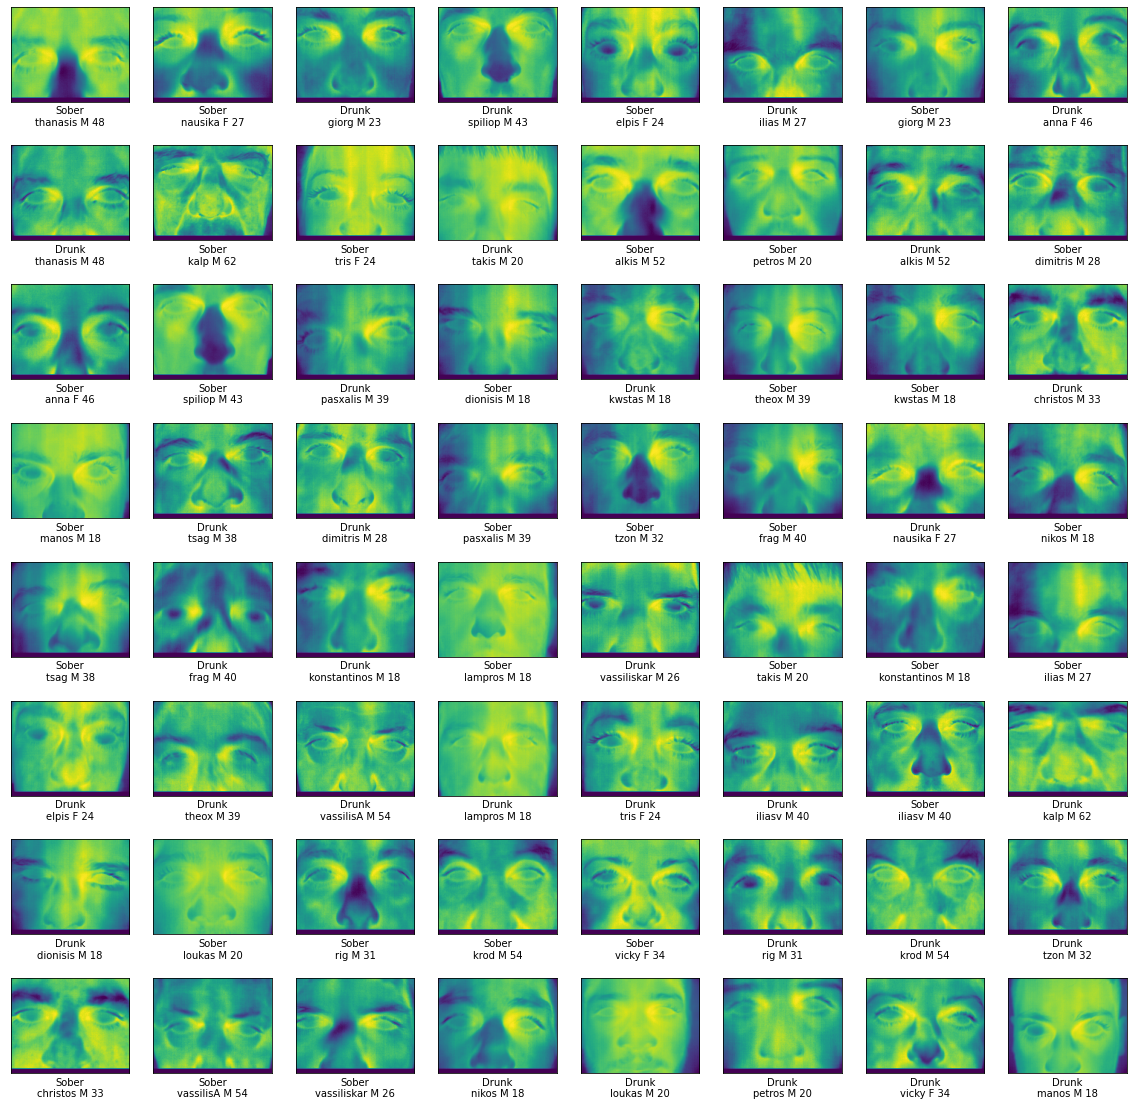

In [ ]:
def plot_dataset(subjects, width=20, height=20):
    # Calculate grid
    grid_size = math.ceil(math.sqrt(len(subjects)))

    fig = plt.figure(figsize=(width, height))
    for i in range(len(subjects)):
        plt.subplot(grid_size, grid_size, 1 + i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(subjects[i].thermal_sum_normalized)

        label = "Drunk" if subjects[i].drunk else "Sober"
        label += "\n"
        label += subjects[i].name
        label += " "
        label += subjects[i].sex
        label += " "
        label += str(subjects[i].age)

        plt.xlabel(label)


# Parse dataset
train_subjects = parse_dataset_folder(DATASET_TRAIN_PATH)
validation_subjects = parse_dataset_folder(DATASET_VALIDATION_PATH)

# Read images
print("Parsing images for training set...")
for x in train_subjects:
    x.parse_image()

print("Parsing images for validation set...")
for x in validation_subjects:
    x.parse_image()

plot_dataset(train_subjects)

## 6. Pickle data

In [ ]:
data = {
    "train": train_subjects,
    "validation": validation_subjects,
}

# curr_datetime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# filename = '{}_{}.pickle'.format('data', curr_datetime)
with open(PICKLE_PATH, "wb") as f:
    pickle.dump(data, f)

print("Pickle size:", pathlib.Path(PICKLE_PATH).stat().st_size / 1024 / 1024 / 1024)


Pickle size: 1.2451493376865983


## 7. Train

Input data shape: 128x160
Train data: 64
Validation data: 16
Train data (augmented): 384
Validation data (augmented): 96
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 158, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 79, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 77, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 36, 64)        18496     

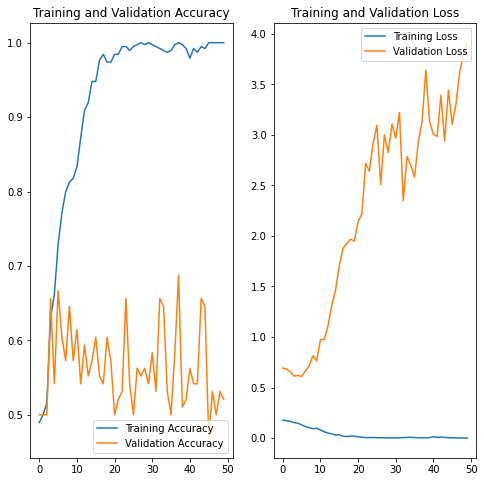

In [ ]:
def get_dataset(data, dataset, sum=True):
    if sum:
        images = np.array([x.thermal_sum_normalized for x in data[dataset]])
        labels = np.array([x.drunk for x in data[dataset]])
    else:
        frames = len(data[dataset][0].thermal_frames_normalized)
        size = frames * len(data[dataset])

        images = np.zeros((size, 128, 160))
        c = 0
        for x in data[dataset]:
            for image in x.thermal_frames_normalized:
                images[c] = image
                c += 1

        labels = np.zeros((size,))
        c = 0
        for x in [x.drunk for x in data[dataset]]:
            # print(x)
            for i in range(frames):
                # print(c*size + i)
                labels[c*frames + i] = x
            c += 1

    return images, labels


def augment_dataset(data, labels, times=4):
    target_data_width, target_data_height = data[0].shape

    # Data Augmentation
    data_augmentation = tf.keras.Sequential(
        [
            layers.RandomZoom(
                DATA_AUGMENTATION_ZOOM,
                input_shape=(target_data_width, target_data_height, 1),
            )
        ]
    )

    if DATA_AUGMENTATION_FLIP_ENABLED:
        data_augmentation.add(layers.RandomFlip(DATA_AUGMENTATION_FLIP))

    if DATA_AUGMENTATION_ROTATION_ENABLED:
        data_augmentation.add(layers.RandomRotation(DATA_AUGMENTATION_ROTATION))

    # data_augmentation.summary()

    for i in range(len(labels)):
        target_data_width, target_data_height = data[i].shape

        for _ in range(times):
            target_image = data[i].reshape(
                (-1, target_data_width, target_data_height, 1)
            )
            augmented_data = (
                data_augmentation(target_image)
                .numpy()
                .reshape(target_data_width, target_data_height)
            )

            # Append augmented image and label
            data = np.vstack((data, augmented_data[None]))
            labels = np.append(labels, labels[i])

    return data, labels

# Load dataset
with open(PICKLE_PATH, "rb") as f:
    data = pickle.load(f)

train_data, train_labels = get_dataset(data, "train", USE_SUM)
validation_data, validation_labels = get_dataset(data, "validation", USE_SUM)

# Get input data size
data_width, data_height = train_data.shape[1:]
print(f"Input data shape: {data_width}x{data_height}")

# Augment data
print(f"Train data: {len(train_data)}")
print(f"Validation data: {len(validation_data)}")
if DATA_AUGMENTATION:
    train_data, train_labels = augment_dataset(train_data, train_labels, DATA_AUGMENTATION_AMOUNT)
    validation_data, validation_labels = augment_dataset(
        validation_data, validation_labels, DATA_AUGMENTATION_AMOUNT
    )
    print(f"Train data (augmented): {len(train_data)}")
    print(f"Validation data (augmented): {len(validation_data)}")

# Model
model = models.Sequential()
model.add(layers.Conv2D(
    64,
    (3, 3),
    activation="relu",
    input_shape=(data_width, data_height, 1)
))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1))
model.summary()

# Print model
utils.plot_model(
    model, to_file="model_plot.png", show_shapes=True, show_layer_names=True
)

# Compile model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Train model
history = model.fit(
    train_data,
    train_labels,
    batch_size=32,
    shuffle=True,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHT,
    validation_data=(validation_data, validation_labels),
)

# Evaluate model
validation_loss, validation_accuracy = model.evaluate(
    validation_data, validation_labels, verbose=2
)

# Plot graphs
print(validation_accuracy)

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.savefig("plot.png")
